# **AI for Healthcare**

## **Overview**

In this notebook, a binary classifier model is developed to detect a specific health condition by analyzing medical data. The dataset consists of 500 patient data, including 70 medical indicators (features) and a target (label) variable. It is divided into 3 sets for different purposes. The classification model is trained solely on the training set (300 samples), has its hyperparameters validated with the validation set (100 samples), and is ultimately evaluated using the testing set (100 samples).



## **Setting up the environment**

Here various python libraries are used to develop the classification model.

In [1]:
#ignore warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

# models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# preprocessing data for feature engineering
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import  mutual_info_classif, f_classif
from sklearn.metrics import nan_euclidean_distances

#automated hyperparameter tuning
from flaml import AutoML
from flaml.default import LGBMClassifier

# evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score




## **Data Preparation**

In [2]:
# Load data
trainset = pd.read_csv('dataset/train_1.csv',index_col='ID')
validset = pd.read_csv('dataset/val_1.csv',index_col='ID')
test_X = pd.read_csv('dataset/test_1.csv',index_col='ID')
train_X, train_y = trainset.drop(columns=['Target']), trainset['Target']
valid_X, valid_y = validset.drop(columns=['Target']), validset['Target']

# seed
seed = 33 

# column name
col_name = trainset.drop(columns=['Target']).columns


In [3]:
# data info
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 299
Data columns (total 70 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Indicator1   300 non-null    float64
 1   Indicator2   300 non-null    float64
 2   Indicator3   300 non-null    float64
 3   Indicator4   300 non-null    float64
 4   Indicator5   300 non-null    float64
 5   Indicator6   300 non-null    float64
 6   Indicator7   300 non-null    float64
 7   Indicator8   289 non-null    float64
 8   Indicator9   300 non-null    float64
 9   Indicator10  300 non-null    float64
 10  Indicator11  300 non-null    float64
 11  Indicator12  300 non-null    float64
 12  Indicator13  300 non-null    float64
 13  Indicator14  300 non-null    float64
 14  Indicator15  300 non-null    float64
 15  Indicator16  298 non-null    float64
 16  Indicator17  292 non-null    float64
 17  Indicator18  298 non-null    float64
 18  Indicator19  292 non-null    float64
 19  Indicator20  

In [4]:
# data describe
train_X.describe()

,Indicator1,Indicator2,Indicator3,Indicator4,Indicator5,Indicator6,Indicator7,Indicator8,Indicator9,Indicator10,...,Indicator61,Indicator62,Indicator63,Indicator64,Indicator65,Indicator66,Indicator67,Indicator68,Indicator69,Indicator70
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,289.000000,300.000000,300.000000,...,252.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,7.148367,4.657000,92.130667,327.086667,30.161667,12.882667,24.628317,43.148097,28.739898,1.991333,...,7963.992063,0.930867,13.643667,1.219867,17.473667,11.249000,25.702000,0.976967,3.587367,105.395333
std,2.031859,0.577499,7.360392,10.842115,2.836179,1.153343,6.179677,4.033601,7.740901,0.606968,...,1883.233267,0.195578,2.914167,0.422253,1.107684,0.774488,3.356748,0.070449,0.920285,14.939854
min,2.620000,2.690000,61.900000,280.000000,18.500000,11.100000,1.543000,31.400000,7.900000,0.750000,...,2299.000000,0.360000,6.200000,0.460000,14.500000,8.100000,18.300000,0.700000,1.380000,62.700000
25%,5.790000,4.310000,89.575000,321.750000,29.100000,12.100000,20.530250,40.500000,23.836681,1.500000,...,6837.000000,0.800000,11.800000,0.927500,16.700000,10.800000,23.375000,0.940000,2.950000,97.050000
50%,6.900000,4.650000,92.400000,327.500000,30.500000,12.700000,24.588000,42.800000,28.828312,2.000000,...,7942.000000,0.920000,13.700000,1.180000,17.400000,11.200000,25.400000,0.970000,3.435000,106.000000
75%,8.287500,4.960000,96.400000,333.000000,31.600000,13.200000,28.783250,45.100000,33.454066,2.400000,...,8982.500000,1.030000,15.800000,1.410000,18.300000,11.700000,27.600000,1.020000,4.142500,114.175000
max,16.770000,7.080000,112.000000,360.000000,37.500000,18.900000,42.116000,58.900000,49.100000,3.730000,...,18143.000000,2.220000,21.400000,4.190000,20.500000,13.900000,39.600000,1.220000,6.770000,190.500000


### **Feature Importance - F-test and Mutual Information**

Calculate p-value from F-test and mutual information (MI) for each feature using data that has no missing values.  Features are chosen based on an F-test with a p-value below 0.05 or a Mutual Information Score exceeding 0.03.


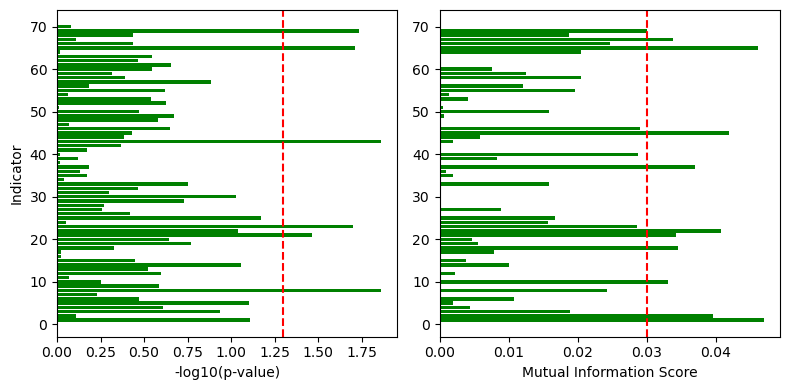

In [5]:
# Compute p-value
f_value, p_value = f_classif(train_X[~train_X.isna().any(axis=1)], train_y[~train_X.isna().any(axis=1)])
col_name = train_X.columns

MI_score_l = []

# Compute MI
# Due to the randomness of mutual information, the score is calculated and averaged over 30 iterations.

for i in range(30):
    MI_score = mutual_info_classif(train_X[~train_X.isna().any(axis=1)], train_y[~train_X.isna().any(axis=1)], random_state=i)
    MI_score_l.append(MI_score)
MI_score = sum(MI_score_l)/len(MI_score_l)

fig,axes = plt.subplots(1,2,figsize=[8,4])

# Plot -log(p-value) for all features
threshold_p_value  = -np.log10(0.05)
axes[0].barh(y=range(1,len(col_name)+1), width=-np.log10(p_value), color='green')
axes[0].set_ylabel('Indicator')
axes[0].set_xlabel('-log10(p-value)')
axes[0].axvline(x=threshold_p_value, color='r', linestyle='--', label='Threshold')

# Plot MI for all features
threshold_MI  = 0.03
axes[1].barh(y=range(1,len(col_name)+1), width=MI_score, color='green')
axes[1].set_xlabel('Mutual Information Score')
axes[1].axvline(x=threshold_MI, color='r', linestyle='--', label='Threshold')

plt.tight_layout()
plt.show()

train_X = train_X.loc[:,(p_value < 0.05) | (MI_score > 0.03)]
valid_X = valid_X.loc[:,(p_value < 0.05) | (MI_score > 0.03)]
test_X = test_X.loc[:,(p_value < 0.05) | (MI_score > 0.03)]

### **Correlation between continuous features**

Check and drop highly correlated features.

highly correlated columns to be dropped: []


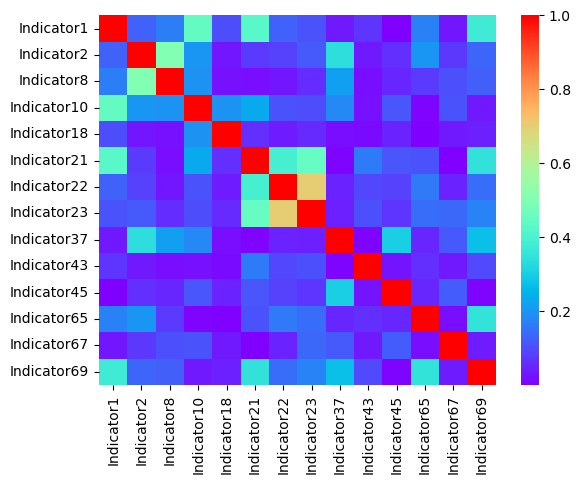

In [6]:

corr_threshold = 0.8
cor =train_X.corr().abs() # get the absolute value of the correlation. We only care about the strength of the correlation but not direction

# plot heatmap
sns.heatmap(cor,cmap="rainbow")
# preserve the indicator with smaller index and drop those highly correlated with larger index.
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool)) 
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)] 

print(f'highly correlated columns to be dropped: {to_drop}')
train_X = train_X.drop(columns=to_drop)
valid_X = valid_X.drop(columns=to_drop)
test_X = test_X.drop(columns=to_drop)


### **Imputation**

Each sample’s missing values are imputed using the mean value from 3 nearest neighbors found in the training set.

In [7]:
def scaled_samples_nan_distance(data_fitted_to_scaler,scaler_class=StandardScaler):
    scaler = scaler_class().fit(data_fitted_to_scaler)
    def nan_distance(x,y,*,missing_values):
        x = scaler.transform(x.reshape(1,-1))
        y = scaler.transform(y.reshape(1,-1))
        return nan_euclidean_distances(x,y,missing_values=missing_values)
    return nan_distance

# Distance between samples is calculated with features scaled by standardization
# But the imputed score is calculated using the original features of the neighbors
imputer = KNNImputer(n_neighbors=3,metric=scaled_samples_nan_distance(data_fitted_to_scaler=train_X))
imputer = imputer.fit(train_X)
train_X = imputer.transform(train_X)
valid_X = imputer.transform(valid_X)
test_X = imputer.transform(test_X)

### **Standardization**

All features are standardized to have a mean of 0 and a standard deviation of 1 

In [8]:
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)
valid_X = scaler.transform(valid_X)
test_X = scaler.transform(test_X)

## **Model training and evaluation**

Evalute model performance based on accuracy, precision, recall, specificity, and AUC.

In [9]:
def evaluation(true_y, pred_y):
    acc = accuracy_score(true_y, pred_y)
    precision = precision_score(true_y, pred_y)
    recall = recall_score(true_y, pred_y, pos_label=1)
    specificity = recall_score(true_y, pred_y, pos_label=0)
    f1 = f1_score(true_y, pred_y)
    auc = roc_auc_score(true_y, pred_y)

    return (acc, precision, recall, specificity, f1, auc)

### **Baseline**

In [10]:

models = [SVC(random_state=seed), 
          LogisticRegression(random_state=seed), 
          DecisionTreeClassifier(random_state=seed), 
          RandomForestClassifier(random_state=seed), 
          AdaBoostClassifier(random_state=seed), 
          KNeighborsClassifier(), # KNeighborsClassifier has no attribute "random_state"
          GaussianNB(), # GaussianNB has no attribute "random_state"
          MLPClassifier(random_state=seed), 
          LGBMClassifier(random_state=seed)
]

records = []

print('==========================================================')
for model in tqdm(models):
    modelname = type(model).__name__
    clf = model
    clf.fit(train_X,train_y)
    pred = clf.predict(valid_X)
    # acc_train = accuracy_score(train_y, pred)
    eval_metric = evaluation(valid_y,pred)
    records.append((modelname,*eval_metric))

100%|██████████| 9/9 [00:00<00:00, 10.43it/s]



### **LGBM with hyperparameters optimized using flaml.AutoML**

In [11]:

automl = AutoML(hpo_method='cfo')

# AutoML gradually adjusts the hyperparameter of LGBM based its accuracy performance on the validation set and retrain it until it converges or the iteration reaches to 5000. 
# The maximum of training time is constrained to 10s.
automl.fit(train_X, train_y, X_val=valid_X,y_val=valid_y,task="classification", max_iter=5000,train_time_limit=10,estimator_list=["lgbm"],metric="accuracy",seed=seed,verbose=1)


In [12]:
# save model

with open("checkpoint/automl_lgbm.pkl", "wb") as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [13]:
# best hyperparameter config found 

automl.best_config

{'n_estimators': 14,
 'num_leaves': 4,
 'min_child_samples': 22,
 'learning_rate': np.float64(0.517586978696495),
 'log_max_bin': 7,
 'colsample_bytree': np.float64(0.8197537630180586),
 'reg_alpha': np.float64(0.0016373615477813118),
 'reg_lambda': np.float64(1.529900789026623)}

In [14]:

# Load best model
with open("checkpoint/automl_lgbm.pkl", "rb") as f:
    model = pickle.load(f)

# Make predictions
pred = automl.predict(valid_X)

# Combine the evaluation of the optimized model with the baseline results
records_df = pd.DataFrame(records+[(f'{automl.best_estimator} fine-tuned by FLAML',*evaluation(valid_y,pred))],columns=['Model', 'Accuracy', 'Precision','Recall', 'Specificity', 'F1','AUC'])

records_df.to_csv('experiment_records.csv',index=False)

records_df

,Model,Accuracy,Precision,Recall,Specificity,F1,AUC
0,SVC,0.52,0.625000,0.192308,0.875000,0.294118,0.533654
1,LogisticRegression,0.51,0.565217,0.250000,0.791667,0.346667,0.520833
2,DecisionTreeClassifier,0.43,0.444444,0.384615,0.479167,0.412371,0.431891
3,RandomForestClassifier,0.50,0.555556,0.192308,0.833333,0.285714,0.512821
4,AdaBoostClassifier,0.57,0.621622,0.442308,0.708333,0.516854,0.575321
5,KNeighborsClassifier,0.48,0.500000,0.326923,0.645833,0.395349,0.486378
6,GaussianNB,0.55,0.612903,0.365385,0.750000,0.457831,0.557692
7,MLPClassifier,0.47,0.485714,0.326923,0.625000,0.390805,0.475962
8,LGBMClassifier,0.50,0.541667,0.250000,0.770833,0.342105,0.510417
9,lgbm fine-tuned by FLAML,0.63,0.727273,0.461538,0.812500,0.564706,0.637019


In [15]:
# Predict Testing data
pred = model.predict(test_X)
pd.DataFrame(pred).reset_index().rename(columns={
    'index': 'ID'
}).to_csv('test_prediction.csv',index=False)